In [94]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy
import scipy
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib.widgets import Slider
print(scipy.__version__)

0.18.1


### Workshop Agenda
1. Simple Class and Lambdas
* Matrix Multiplication
    * Timing
    * Profile and Debug
*  Polyfit
* Jupyter
    * Root Finding
    * Curve Fitting
    * Hydrogen Atom
    * Images, Fourier Transforms, SVD

### Timing Stuff with %timeit
%timeit is one of the built in 'magic' commands in Jupyter.

In [85]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3  %%rub

In [91]:
%timeit -n 100 numpy.random.random((100,100))**4

100 loops, best of 3: 694 µs per loop


### Root Finding
Let's begin with some root finding - we'll use the [scipy.optimize.brentq](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.brentq.html) routine to find the zeros of a function.

<IPython.core.display.Javascript object>


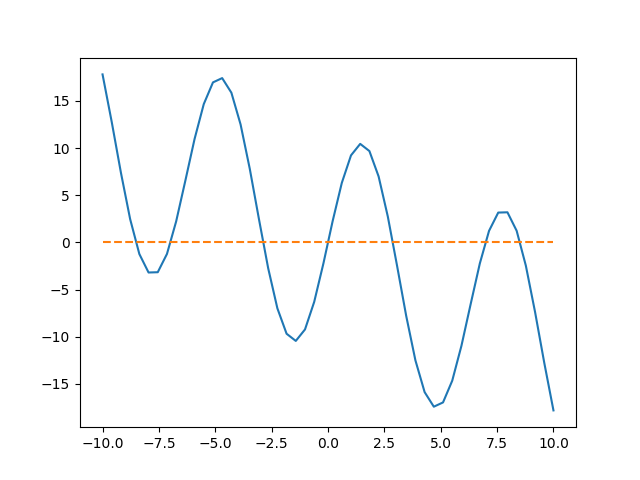

In [65]:
def crazy_function(x, s):
    return s**3*numpy.sin(x)+numpy.tan(s)*x

s=2.3
x = numpy.linspace(-10,10,50)
plt.figure()
plt.plot(x, crazy_function(x,s))
plt.plot(x, numpy.zeros_like(x),'--')
plt.show()

In [81]:
%%time
x_zero = scipy.optimize.brentq(crazy_function, 2.5, 3.3, s)
print("x_zero = ", x_zero)
print("crazy_function(x_zero) = ", crazy_function(x_zero,s))

x_zero =  2.8740360205078144
crazy_function(x_zero) =  0.0
Wall time: 1 ms


### Curve Fitting
Now we'll try to fit some noisy data to our favorite function with [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [83]:
def my_func(x, a, b, c):
    return a*numpy.exp(-b*x) + c

x = numpy.linspace(0,10,20)
data = my_func(x, 2, 0.3, 1)
noise = 0.1*numpy.random.normal(size=len(data))
data += noise
numpy.savetxt("data.dat", data)

In [84]:
%%time
data = numpy.loadtxt("data.dat")
popt, pcov = scipy.optimize.curve_fit(my_func, x, data)
print(popt)
print(pcov)

[ 2.01858293  0.28762367  0.95292314]
[[ 0.0055163  -0.00073767 -0.00322218]
 [-0.00073767  0.00098028  0.00204899]
 [-0.00322218  0.00204899  0.00523018]]
Wall time: 12 ms


<IPython.core.display.Javascript object>


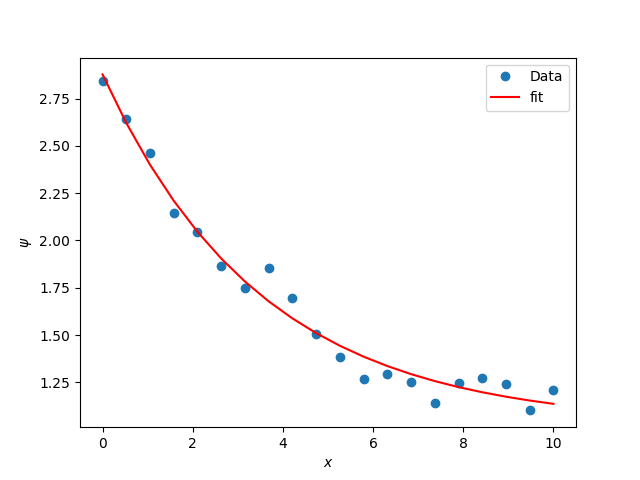

In [69]:
plt.figure()
plt.plot(x, data, 'o', label="Data")
plt.plot(x, my_func(x, *popt), 'r-', label='fit')
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi$')
plt.legend()
plt.show()

### Hydrogen Wavefunctions
The wavefunctions of the Hydrogen atom are given by:
$$ \psi_{nlm}=\sqrt{\left( \frac{2}{na}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]^3}}e^{-r/na}\left( \frac{2r}{na} \right)^l \left[ L_{n-l-1}^{2l+1}(2r/na)\right]Y_l^m(\theta,\phi)$$
Let's set $a=1$, and try to obtain 3D plots of the density isosurfaces.

In [70]:
def hydrogen_wf(n,l,m,X,Y,Z):
    R = numpy.sqrt(X**2+Y**2+Z**2)
    Theta = numpy.arccos(Z/R)
    Phi = numpy.arctan2(Y,X)
    
    rho = 2.*R/n
    s_harm=scipy.special.sph_harm(m, l, Phi, Theta)
    l_poly = scipy.special.genlaguerre(n-l-1,2*l+1)(rho)
    
    prefactor = numpy.sqrt((2./n)**3*math.factorial(n-l-1)/(2.*n*math.factorial(n+l)))
    
    wf = prefactor*numpy.exp(-rho/2.)*rho**l*s_harm*l_poly
    wf = numpy.nan_to_num(wf)
    return wf

In [71]:
dz=0.5
zmin=-10
zmax=10
x = numpy.arange(zmin,zmax,dz)
y = numpy.arange(zmin,zmax,dz)
z = numpy.arange(zmin,zmax,dz)
X,Y,Z = numpy.meshgrid(x,y,z)
data = hydrogen_wf(4,2,0,X,Y,Z)
data = abs(data)**2

R = numpy.sqrt(X**2+Y**2+Z**2)

C:\Users\pakij\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


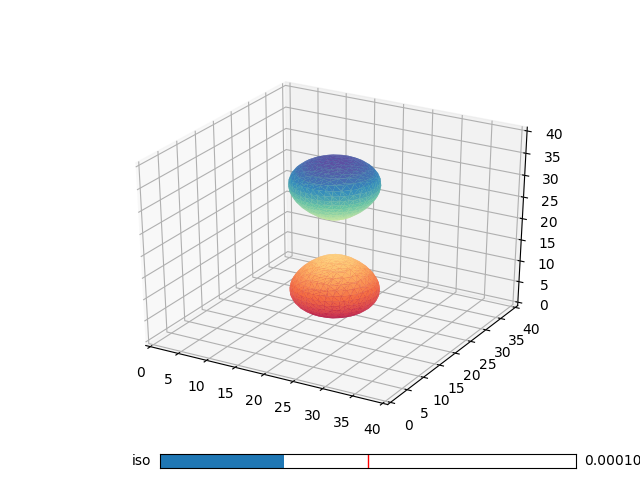

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0,len(x)])
ax.set_ylim([0,len(y)])
ax.set_zlim([0,len(z)])
ax.set_title(r"Hydrogen Isosurfaces, $|\psi_{nlm}|^2$")
max_val = numpy.max(data)

verts, faces = measure.marching_cubes(data, max_val/2, spacing = (1,1,1))
result=ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2], cmap ='Spectral', lw=0)

sli = Slider(plt.axes([0.25, 0.025, 0.65, 0.03]), "iso", 0, max_val, valinit=max_val/2, valfmt='%1.5f')

def update(val):
    ax.clear()
    verts, faces = measure.marching_cubes(data, sli.val, spacing = (1,1,1))
    result = ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2], cmap ='Spectral', lw=0)
    ax.set_xlim([0,len(x)])
    ax.set_ylim([0,len(y)])
    ax.set_zlim([0,len(z)])

sli.on_changed(update)
plt.show()

### Displaying Images, Fourier Tranforms, SVD
We can change the resolution of an image by Fourier Transforming or taking the SVD. By removing high frequency data or small singular values, we get a lower resolution image.  This can be used for image compression.


In [170]:
image=mpimg.imread('Lichtenstein_img_processing_test.png')

<IPython.core.display.Javascript object>


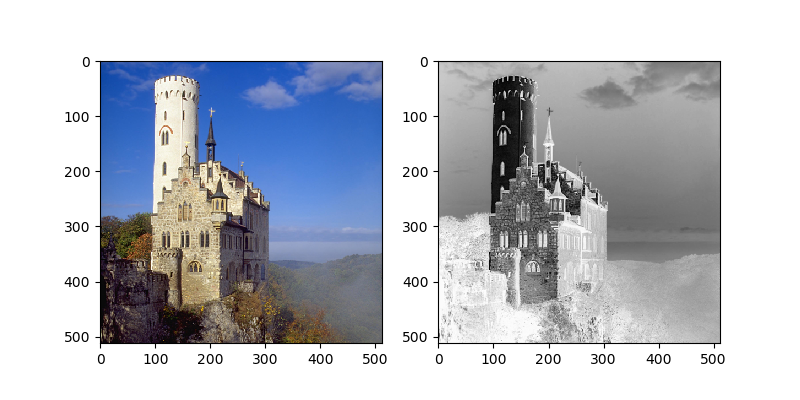

In [171]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
image_bw = (image[:,:,1] + image[:,:,0]+  image[:,:,2])/3
plt.imshow(image_bw,cmap='Greys')

In [168]:
image_fft = numpy.fft.rfft2(image_bw)
xsize,ysize=image_fft.shape
print(xsize)
print(ysize)
image_fft[:,10:ysize]=0
image_ifft = numpy.fft.irfft2(image_fft)

512
257


<IPython.core.display.Javascript object>


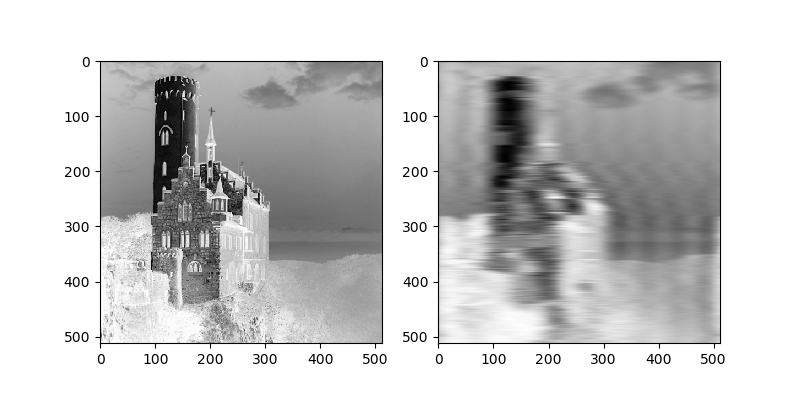

In [169]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(baboon_r,cmap='Greys')
plt.subplot(122)
plt.imshow(image_ifft,cmap='Greys')

In [198]:
(U,S,V) = numpy.linalg.svd(image_bw)
singvals = numpy.diag(S)
sing_size = singvals.shape[0]
max_sing = 100
singvals[max_sing:,max_sing:] = 0
image_reconstructed = numpy.dot(U, numpy.dot(singvals,V))

<IPython.core.display.Javascript object>


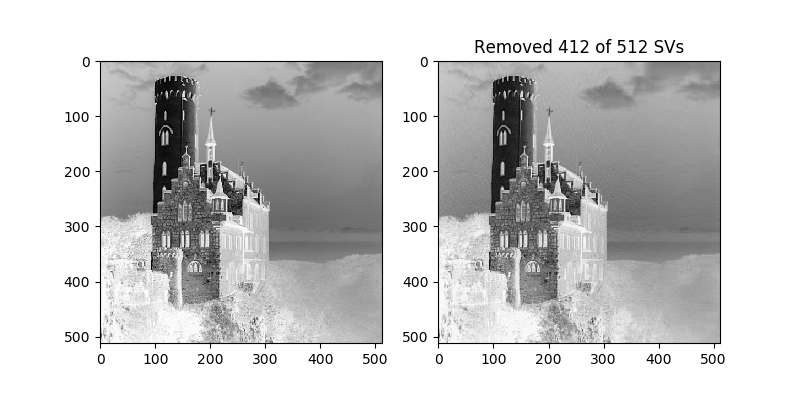

In [205]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(baboon_r,cmap='Greys')
plt.subplot(122)
plt.imshow(image_reconstructed,cmap='Greys')
plt.title("Removed "+str(sing_size-max_sing)+" of "+str(sing_size)+" SVs")